In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
#matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import math
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import svm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import plotly.express as px

from sklearn.metrics import confusion_matrix

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
ds_original = pd.read_csv('dataset_phishing.csv', header=0, delimiter=',',decimal=',')

print("Original dataset dimensions:", ds_original.shape)

#Podem prescindir de la columna de strings amb la url perquè toda la informació que ens pot donar ja queda reflexada en la resta de característiques
dataset = ds_original.drop(columns = "url")

Original dataset dimensions: (11430, 89)


In [3]:
# L' objectiu és predir si una url és de phishing o no, per tant la variable dependent serà STATUS.
y = dataset[:]["status"] 
x = dataset.drop(columns = "status")

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 87


In [4]:
# Els "domain_age" amb -1 indiquen que no es coneix la dada. Els substituïm per la mitja

known_domain_age = x.loc[x['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)
mean_domain_age

x.loc[x["domain_age"] == -1, 'domain_age'] = mean_domain_age

In [5]:
print(y.describe())
status_labels = y.copy()
y = y.replace({"phishing" : 1, "legitimate" : 0})

print("\nContingut de Y:", set(y))

print("\nDimensionalitat de X:", x.shape)

count          11430
unique             2
top       legitimate
freq            5715
Name: status, dtype: object

Contingut de Y: {0, 1}

Dimensionalitat de X: (11430, 87)


Incialment a $Y$ teniem les etiques de "phishing" i "legitimate". Per poder fer regressió ens interessa convertir-les en un valor binari on 1 indica _Phishing_ i 0 no.
També veïem que les mostres estan repartides al 50% entre les dues categoríes (Com s'indica a la descripció de Kaggle).

Les columnes de $X$ que tenen nombres decimals apareixen amb un tipus de dada desconegut anomenat _object_. Aixó pot crear problemes més endavant, per tant es bona idea fer una conversió a tipus _float_.

In [6]:
type_of_cols = [x.dtypes == object][0]
for col in range(x.shape[1]):
    if type_of_cols[col]:
        x[x.columns[col]] = x[x.columns[col]].astype('float')

Now $X$ contain just numeric values.

A good idea for discarding some columns would be to drop those whose mean is or is very close to 0. We can do this only with the features that represent some kind of counter because that means that most of the samples doesn't register that feature.

In [7]:
columns_to_drop = []

for col in range(x.shape[1]):
    name_of_feature = x.columns[col]
    if np.mean(x[name_of_feature]) <= 0.01:
        columns_to_drop.append(name_of_feature)
        
x[columns_to_drop].describe()

nb_or  nb_tilde   nb_star  nb_comma  nb_dollar  nb_dslash  punycode  \
count 11430.000 11430.000 11430.000 11430.000  11430.000  11430.000 11430.000   
mean      0.000     0.007     0.001     0.004      0.002      0.007     0.000   
std       0.000     0.081     0.026     0.103      0.077      0.081     0.019   
min       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
25%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
50%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
75%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
max       0.000     1.000     1.000     4.000      6.000      1.000     1.000   

           port  path_extension  nb_external_redirection  brand_in_subdomain  \
count 11430.000       11430.000                11430.000           11430.000   
mean      0.002           0.000                    0.003               0.004   
std       0.049           0.013                    0.056               0.064   
min       0.000           0.000                    0.000               0.000   
25%       0.000           0.000                    0.000               0.000   
50%       0.000           0.000                    0.000               0.000   
75%       0.000           0.000                    0.000               0.000   
max       1.000           1.000                    1.000               1.000   

       brand_in_path  ratio_nullHyperlinks  ratio_intRedirection  \
count      11430.000             11430.000             11430.000   
mean           0.005                 0.000                 0.000   
std            0.070                 0.000                 0.000   
min            0.000                 0.000                 0.000   
25%            0.000                 0.000                 0.000   
50%            0.000                 0.000                 0.000   
75%            0.000                 0.000                 0.000   
max            1.000                 0.000                 0.000   

       ratio_intErrors  submit_email       sfh    iframe  popup_window  \
count        11430.000     11430.000 11430.000 11430.000     11430.000   
mean             0.000         0.000     0.000     0.001         0.006   
std              0.000         0.000     0.000     0.036         0.077   
min              0.000         0.000     0.000     0.000         0.000   
25%              0.000         0.000     0.000     0.000         0.000   
50%              0.000         0.000     0.000     0.000         0.000   
75%              0.000         0.000     0.000     0.000         0.000   
max              0.000         0.000     0.000     1.000         1.000   

       onmouseover  right_clic  
count    11430.000   11430.000  
mean         0.001       0.001  
std          0.034       0.037  
min          0.000       0.000  
25%          0.000       0.000  
50%          0.000       0.000  
75%          0.000       0.000  
max          1.000       1.000

Veient els màxims i mínims d'aquestes columnes queda clar que totes aquestes columnes indiquen un compte d'alguna cosa o són variables binaries i, en qualsevol cas, no donen suficient informació per ajudar en la classifició. 

In [8]:
x = x.drop(columns = columns_to_drop)
print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 66


Funcions de regressio

In [9]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()


def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    
    # Retornem el model entrenat
    return regr

In [10]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x.values, y)

r2_table = np.zeros((x_train.shape[1], 2))

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)
    r2 = r2_score(y_val, regr.predict(x_v))
    
    r2_table[i, 1] = r2
    r2_table[i, 0] = i

We create a reduced dataset with the best atributes

In [11]:
best_atributes = r2_table[r2_table[:, 1].argsort()[::-1]][:,0].astype('int')

reduced_dataset = x[x.columns[best_atributes[:15]]]
reduced_dataset = reduced_dataset.assign(status = y.values)

X = reduced_dataset.drop(columns='status').values
Y = reduced_dataset.filter(['status']).values

In [12]:
reduced_dataset

google_index  page_rank  nb_www  domain_age  ratio_digits_url  ip  \
0                 1          4       1    4812.587             0.000   0   
1                 1          2       0    5767.000             0.221   1   
2                 1          0       0    4004.000             0.151   1   
3                 0          3       0    4812.587             0.000   0   
4                 0          6       1    8175.000             0.000   0   
...             ...        ...     ...         ...               ...  ..   
11425             0          6       1    5396.000             0.000   0   
11426             1          0       1    6728.000             0.024   0   
11427             1         10       1    8515.000             0.143   1   
11428             0          4       1    2836.000             0.000   0   
11429             1          0       1    4812.587             0.086   1   

       domain_in_title  phish_hints  nb_qm  nb_hyperlinks  length_url  \
0                    0            0      0             17          37   
1                    1            0      0             30          77   
2                    1            0      1              4         126   
3                    1            0      0            149          18   
4                    0            0      0            102          55   
...                ...          ...    ...            ...         ...   
11425                0            0      0            199          45   
11426                1            0      1              3          84   
11427                0            0      1             68         105   
11428                1            0      0             32          38   
11429                1            3      1             21         477   

       ratio_intHyperlinks  nb_eq  nb_slash  shortest_word_host  status  
0                    0.529      0         3                   3       0  
1                    0.967      0         5                  19       1  
2                    1.000      3         5                   3       1  
3                    0.973      0         2                   5       0  
4                    0.471      0         5                   3       0  
...                    ...    ...       ...                 ...     ...  
11425                0.884      0         4                   3       0  
11426                1.000      1         5                   3       1  
11427                0.471      1         5                   3       0  
11428                0.375      0         3                   3       0  
11429                0.429      9         4                   2       1  

[11430 rows x 16 columns]

Correlació entre variables

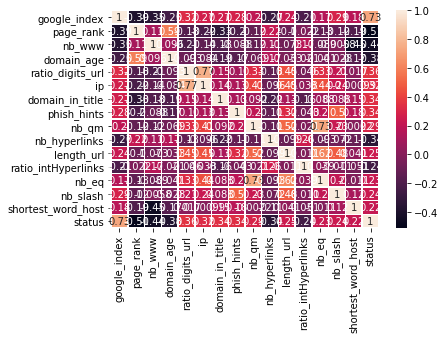

In [13]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
#relacio = sns.pairplot(smaller)

Utilities

In [14]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

PCA Analysis

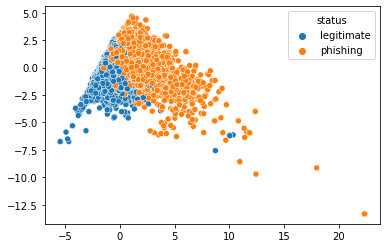

In [15]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=2)[2]
pca = torch.matmul(X_torch, V[:, :2])

sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = status_labels);

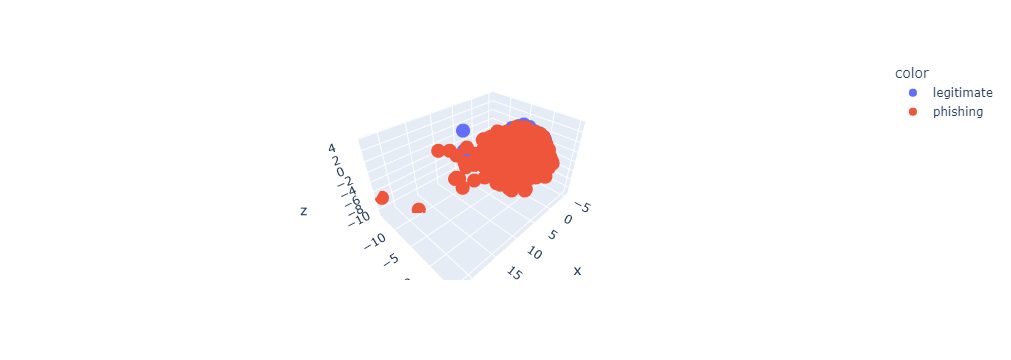

In [16]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=3)[2]
pca = torch.matmul(X_torch, V[:, :3])

df = px.data.iris()
fig = px.scatter_3d(x = pca[:, 0], y = pca[:, 1], z = pca[:, 2], color = status_labels)
fig.show()

#### Logistic regression

In [62]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=42)

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

X_torch, Y_torch = torch.Tensor(scaled), torch.Tensor(Y)

data_torch = torch.cat((X_torch, Y_torch), 1)
data_torch
X_train

tensor([[ 0.9343, -0.4674, -0.8936,  ..., -0.2937, -0.6852, -0.7662],
        [ 0.9343,  0.7152,  1.0989,  ..., -0.2937,  0.3774, -0.5124],
        [ 0.9343,  0.3210, -0.8936,  ..., -0.2937, -0.1539, -0.2587],
        ...,
        [ 0.9343, -0.4674, -0.8936,  ..., -0.2937, -0.6852, -0.2587],
        [ 0.9343, -0.4674, -0.8936,  ..., -0.2937, -0.6852, -0.5124],
        [ 0.9343,  0.7152, -0.8936,  ..., -0.2937,  1.4400, -0.7662]])

In [49]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [50]:
epochs = 2000
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.01

In [51]:
model = LogisticRegression(input_dim,output_dim) #Creem el model

criterion = torch.nn.BCELoss() # Definim el criteri de la funció de cost

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Definim el mètode per reduir el cost

In [59]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter += 1
    if iter % (epochs/5) == 0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = model(X_test)
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(outputs.round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  28%|██▊       | 563/2000 [00:00<00:01, 1085.39it/s]

Iteration: 400. 
Test - Loss: 0.21974919736385345. Accuracy: 92.20253718285214
Train -  Loss: 0.2030317783355713. Accuracy: 93.26334208223972



Training Epochs:  48%|████▊     | 956/2000 [00:01<00:01, 818.38it/s] 

Iteration: 800. 
Test - Loss: 0.21733593940734863. Accuracy: 92.2244094488189
Train -  Loss: 0.20032812654972076. Accuracy: 93.35083114610674



Training Epochs:  64%|██████▍   | 1283/2000 [00:01<00:00, 775.34it/s]

Iteration: 1200. 
Test - Loss: 0.2155480533838272. Accuracy: 92.2681539807524
Train -  Loss: 0.19832992553710938. Accuracy: 93.43832020997375



Training Epochs:  85%|████████▍ | 1694/2000 [00:01<00:00, 814.43it/s]

Iteration: 1600. 
Test - Loss: 0.21417579054832458. Accuracy: 92.30096237970254
Train -  Loss: 0.1968042403459549. Accuracy: 93.48206474190727



Training Epochs: 100%|██████████| 2000/2000 [00:02<00:00, 844.57it/s]

Iteration: 2000. 
Test - Loss: 0.21309514343738556. Accuracy: 92.41032370953631
Train -  Loss: 0.19561021029949188. Accuracy: 93.35083114610674



In [52]:
from sklearn.model_selection import KFold

k_folds = 5
kfold = KFold(n_splits = k_folds, shuffle=True)    

In [58]:

for fold, (train_ids, test_ids) in enumerate(kfold.split(data_torch)):
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    #print(train_ids)
    for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
        x = X_torch[train_ids, :-1]
        labels = X_torch[train_ids, -1]
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        print(x.shape)
        outputs = model(x)
        loss = criterion(outputs, labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)

        iter += 1
        if iter % (epochs/5) == 0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = model(x)
                loss_test = criterion(outputs_test, labels)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += labels.size(0)
                correct_test += np.sum(predicted_test == labels.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += labels.size(0)
                correct += np.sum(outputs.round().detach().numpy() == labels.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([9144, 14])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9144x14 and 15x1)

### SVM

In [22]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=1)

C = 0.05
models = (svm.SVC(),
         svm.LinearSVC(C=C),
         svm.SVC(kernel = 'rbf', gamma = 0.7, C=C),
         svm.SVC(kernel = 'poly', degree = 2, C=C),
         svm.SVC(kernel = 'poly', degree = 3, C=C))

models = (model.fit(X_train,y_train.flatten()) for model in models)

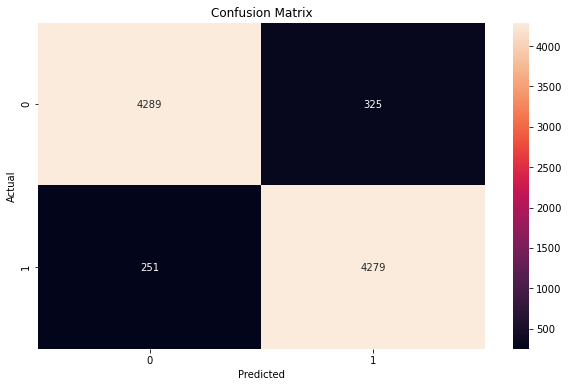

Accuracy "Without kernel": 0.937007874015748 




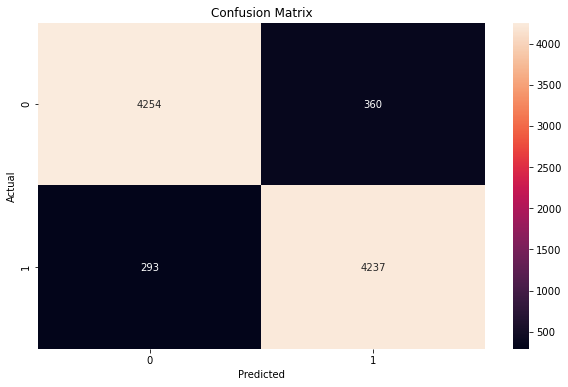

Accuracy "Linear kernel": 0.9285870516185477 




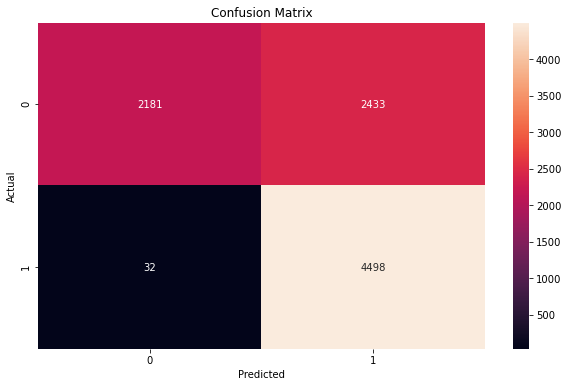

Accuracy "RBF kernel": 0.730424321959755 




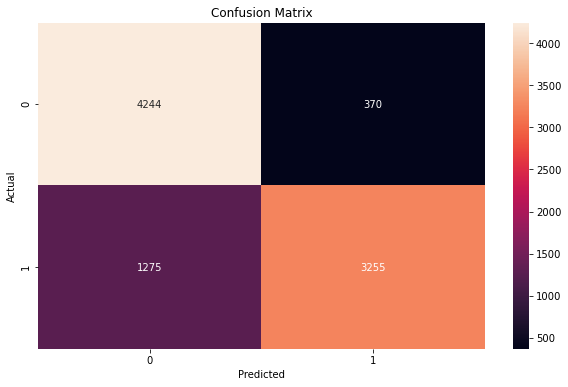

Accuracy "2nd degree Polynomial kernel": 0.8201006124234471 




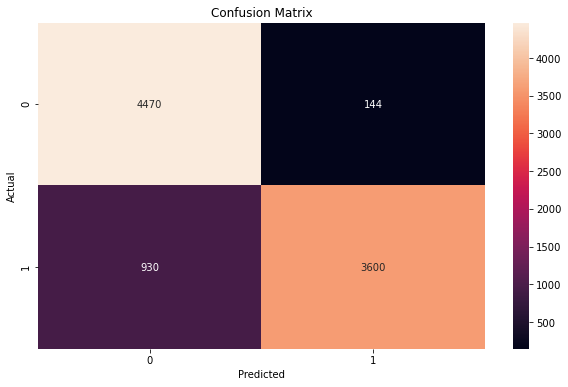

Accuracy "3nd degree Polynomial kernel": 0.8825459317585301 




In [23]:
kernel_names = ["Without kernel", "Linear kernel", "RBF kernel",\
                "2nd degree Polynomial kernel", "3nd degree Polynomial kernel"]

for i, model in enumerate(models):
    predict = model.predict(X_test)
    visualize_confusion_matrix(predict, y_test.flatten())
    print("Accuracy \"" + kernel_names[i] + str("\":"), sum(predict == y_test.flatten())/predict.size, "\n\n")
    